# LV3 - Klasifikacija teksta pomoću strojnog učenja



## Ciljevi laboratorijske vježbe:


*   Pripremiti označene skupove podataka za klasifikaciju teksta
*   Trenirati klasifikator
*   Evaluirati performanse klasifikatora (točnost, preciznost, odziv)



## 1. Instalacija biblioteka

In [ ]:
from google.colab import files
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.svm import LinearSVC
import re
import spacy
nlp = spacy.load("en_core_web_sm")
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.pipeline import Pipeline

## 2. Učitavanje dataseta Coronavirus tweets NLP - Text Classification

Potrebno je preuzeti javni dataset s platforme Kaggle. Kako bi preuzimanje bilo uspješno, potrebno je preuzeti datoteku `kaggle.json` sa svog Kaggle korisničkog profila i uploadati ju prilikom izvođenja sljedećeg programskog koda. Moguće je i preuzeti dataset i prenijeti ga u Google Colab ručno. Dataset možete preuzeti na [linku](https://www.kaggle.com/datasets/datatattle/covid-19-nlp-text-classification).



In [ ]:
files.upload()
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!pip install kaggle
!kaggle datasets download -d datatattle/covid-19-nlp-text-classification

KeyboardInterrupt: 

In [ ]:
# Ovaj dataset dolazi kodiran u ISO-8859-1 (Latin-1), pa je potrebno specificirati encoding parametar
train = pd.read_csv("Corona_NLP_train.csv", encoding="latin1")
test = pd.read_csv("Corona_NLP_test.csv", encoding="latin1")

train.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


## 3. Priprema podataka



### a) Odabir značajki

In [ ]:
selected_features_train = train[['OriginalTweet', 'Sentiment']]
selected_features_test = test[['OriginalTweet', 'Sentiment']]

### b) Provjera nedostajućih vrijednosti

In [ ]:
print(selected_features_train.shape[0])
print(f"Broj nedostajućih vrijednosti:\n{selected_features_train.isnull().sum()}")

41157
Broj nedostajućih vrijednosti:
OriginalTweet    0
Sentiment        0
dtype: int64


Budući da stupac Location neće biti korišten pri treniranju modela, nedostajuće vrijednosti se mogu zanemariti.

In [ ]:
# ZADATAK: Provjerite nedostajuće vrijednosti u testnom skupu te riješite na prikladan način ukoliko ih ima
print(selected_features_test.shape[0])
print(f"Broj nedostajućih vrijednosti:\n{selected_features_test.isnull().sum()}")

3798
Broj nedostajućih vrijednosti:
OriginalTweet    0
Sentiment        0
dtype: int64


Sentiment
Negative              1041
Positive               947
Neutral                619
Extremely Positive     599
Extremely Negative     592
Name: count, dtype: int64


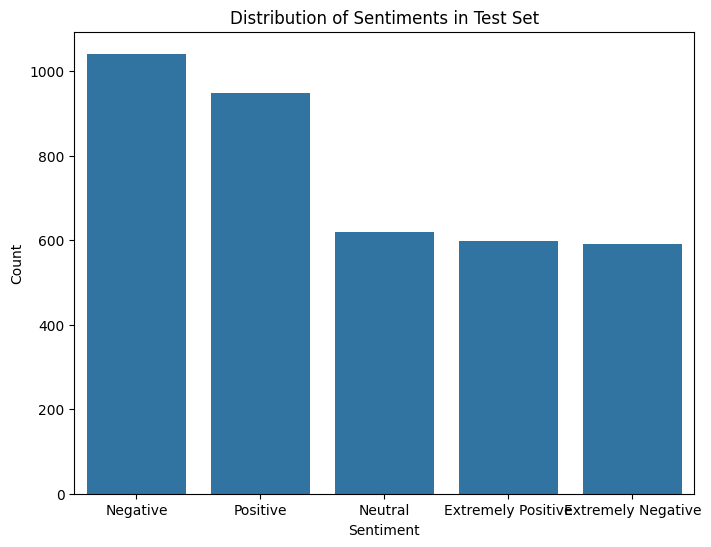

In [ ]:
#ZADATAK: Provjerite broj ponavljanja svake od kategorija tweetova te ih prikžite na grafu koristeći prikladne biblioteke
sentiment_counts = selected_features_test['Sentiment'].value_counts()
print(sentiment_counts)

plt.figure(figsize=(8, 6))
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values)
plt.title('Distribution of Sentiments in Test Set')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

In [ ]:
mapping = {
    'Positive': 'Positive',
    'Extremely Positive': 'Positive',
    'Negative': 'Negative',
    'Extremely Negative': 'Negative',
    'Neutral': 'Neutral'
}

selected_features_train['Sentiment'] = selected_features_train['Sentiment'].map(mapping)
selected_features_test['Sentiment'] = selected_features_test['Sentiment'].map(mapping)

#ZADATAK: Prikažite broj primjeraka u svakoj klasi nakon mapiranja
train = selected_features_train['Sentiment'].value_counts()
print(f"Train: {train}")
test = selected_features_test['Sentiment'].value_counts()
print(f"Test: {test}")

Train: Sentiment
Positive    18046
Negative    15398
Neutral      7713
Name: count, dtype: int64
Test: Sentiment
Negative    1633
Positive    1546
Neutral      619
Name: count, dtype: int64


/tmp/ipython-input-3845756835.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_features_train['Sentiment'] = selected_features_train['Sentiment'].map(mapping)
/tmp/ipython-input-3845756835.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_features_test['Sentiment'] = selected_features_test['Sentiment'].map(mapping)


### c) Lematizacija i čišćenje teksta

In [ ]:
def clean_text(text):
    # Lowercase
    text = text.lower()
    # Remove URLs
    text = re.sub(r'http\S+|www\S+', '', text)
    # Remove mentions
    text = re.sub(r'@\w+', '', text)
    # Remove punctuation and numbers
    text = re.sub(r'[^a-z\s]', '', text)
    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()
    return text

In [ ]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [ ]:
def lemmatize_text(text):
  # ZADATAK: Napišite funkciju za lematizaciju teksta
  tokens = text.split()
  lemmas = [lemmatizer.lemmatize(token) for token in tokens]
  return ' '.join(lemmas)

selected_features_train['clean_tweet'] = selected_features_train['OriginalTweet'].apply(lemmatize_text).apply(clean_text)
selected_features_test['clean_tweet'] = selected_features_test['OriginalTweet'].apply(lemmatize_text).apply(clean_text)

In [ ]:
print(selected_features_train.head())
print(selected_features_test.head())

                                       OriginalTweet Sentiment  \
0  @MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...   Neutral   
1  advice Talk to your neighbours family to excha...  Positive   
2  Coronavirus Australia: Woolworths to give elde...  Positive   
3  My food stock is not the only one which is emp...  Positive   
4  Me, ready to go at supermarket during the #COV...  Negative   

                                         clean_tweet  
0                                            and and  
1  advice talk to your neighbour family to exchan...  
2  coronavirus australia woolworths to give elder...  
3  my food stock is not the only one which is emp...  
4  me ready to go at supermarket during the covid...  
                                       OriginalTweet Sentiment  \
0  TRENDING: New Yorkers encounter empty supermar...  Negative   
1  When I couldn't find hand sanitizer at Fred Me...  Positive   
2  Find out how you can protect yourself and love...  Positive   
3  #Panic

### d) Pretvaranje teksta u vektore značajki (TF-IDF)

TF-IDF (Term Frequency–Inverse Document Frequency) je statistička metoda koja se koristi u obradi prirodnog jezika i pretraživanju informacija za procjenu koliko je određena riječ važna za jedan dokument u odnosu na veću zbirku dokumenata. TF-IDF kombinira dvije komponente:
1. Frekvencija pojma (TF): Mjeri koliko se puta riječ pojavljuje u dokumentu. Veća učestalost sugerira veću važnost. Ako se neki pojam često pojavljuje u dokumentu, vjerojatno je relevantan za sadržaj tog dokumenta.
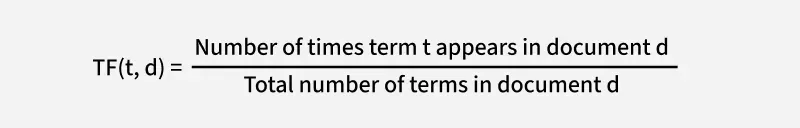

2. Obrnuta frekvencija dokumenta (IDF): Smanjuje težinu uobičajenih riječi koje se pojavljuju u više dokumenata, dok povećava težinu rijetkih riječi. Ako se pojam pojavljuje u manjem broju dokumenata, veća je vjerojatnost da je značajan i specifičan.
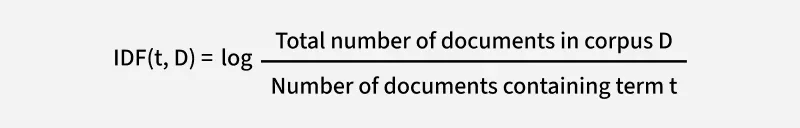

Ova ravnoteža omogućuje TF-IDF-u da istakne pojmove koji su i učestali unutar određenog dokumenta i prepoznatljivi u odnosu na ostatak zbirke dokumenata, što ga čini korisnim alatom za zadatke poput rangiranja pretraživanja, klasifikacije teksta i izdvajanja ključnih riječi.

In [ ]:
tfidf = TfidfVectorizer(stop_words='english', max_features=5000)

X_train = tfidf.fit_transform(selected_features_train['clean_tweet'])
#ZADATAK: Transformirati očišćene tekstualne tweetove u numeričku TF-IDF reprezentaciju na testnom skupu.
X_test = tfidf.transform(selected_features_test['clean_tweet'])

### e) Enkodiranje oznaka

In [ ]:
le = LabelEncoder()

print(selected_features_train['Sentiment'].unique())

y_train = le.fit_transform(selected_features_train['Sentiment'])
y_test = le.transform(selected_features_test['Sentiment'])

y_train = pd.DataFrame(y_train, columns=['Sentiment'])
y_test = pd.DataFrame(y_test, columns=['Sentiment'])
y_train.head()

['Neutral' 'Positive' 'Negative']


,Sentiment
0,1
1,2
2,2
3,2
4,0


## 4. Treniranje modela - Naive Bayes

In [ ]:
param_grid = {'alpha': [0.1, 0.5, 1.0, 2.0]}

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid = GridSearchCV(MultinomialNB(), param_grid, cv=skf, scoring='accuracy')
grid.fit(X_train, y_train)

print("Best alpha:", grid.best_params_)
print("Best cross-val accuracy:", grid.best_score_)

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

Best alpha: {'alpha': 0.1}
Best cross-val accuracy: 0.6775034537827141


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
model = MultinomialNB(alpha = 0.1)
model.fit(X_train, y_train)

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MultinomialNB(alpha=0.1)

## 5. Evaluacija performansi

In [ ]:
y_pred = model.predict(X_test)

print("Classification Report:\n")
print(classification_report(y_test, y_pred, target_names=le.classes_))

print("Confusion Matrix:\n")
print(confusion_matrix(y_test, y_pred))

Classification Report:

              precision    recall  f1-score   support

    Negative       0.72      0.72      0.72      1633
     Neutral       0.63      0.20      0.30       619
    Positive       0.64      0.81      0.71      1546

    accuracy                           0.67      3798
   macro avg       0.66      0.57      0.58      3798
weighted avg       0.67      0.67      0.65      3798

Confusion Matrix:

[[1173   47  413]
 [ 192  122  305]
 [ 270   25 1251]]


## ZADATAK:
Trenirati model koristeći SVM i usporediti performanse s Naive Bayes-om.

In [ ]:
# Define the parameter grid for LinearSVC
param_grid_svm = {'C': [0.1, 1.0, 10.0]}

# Initialize StratifiedKFold for cross-validation
skf_svm = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialize GridSearchCV for LinearSVC
grid_svm = GridSearchCV(LinearSVC(random_state=42, dual=False), param_grid_svm, cv=skf_svm, scoring='accuracy', n_jobs=-1)

# Fit GridSearchCV to the training data
grid_svm.fit(X_train, y_train.values.ravel())

print("Best C for SVM:", grid_svm.best_params_)
print("Best cross-val accuracy for SVM:", grid_svm.best_score_)

# Train the SVM model with the best parameter
svm_model = LinearSVC(C=grid_svm.best_params_['C'], random_state=42, dual=False)
svm_model.fit(X_train, y_train.values.ravel())

# Make predictions on the test set
y_pred_svm = svm_model.predict(X_test)

print("\nClassification Report (SVM):\n")
print(classification_report(y_test, y_pred_svm, target_names=le.classes_))

print("\nConfusion Matrix (SVM):\n")
print(confusion_matrix(y_test, y_pred_svm))

Best C for SVM: {'C': 1.0}
Best cross-val accuracy for SVM: 0.7941056405900613

Classification Report (SVM):

              precision    recall  f1-score   support

    Negative       0.80      0.78      0.79      1633
     Neutral       0.66      0.64      0.65       619
    Positive       0.80      0.83      0.82      1546

    accuracy                           0.78      3798
   macro avg       0.75      0.75      0.75      3798
weighted avg       0.78      0.78      0.78      3798


Confusion Matrix (SVM):

[[1267  136  230]
 [ 127  398   94]
 [ 184   72 1290]]


# Zadatak – samostalan rad na datasetu

### U ovom zadatku studenti će sami proći cijeli proces klasifikacije teksta koristeći metode strojnog učenja – od pripreme podataka do treniranja i usporedbe različitih modela.

Cilj je klasificirati opise proizvoda iz e-trgovine u jednu od četiri kategorije (Electronics, Household, Books, Clothing & Accessories).

### Koraci zadatka:

1. **Pregled dataseta**  
   - Preuzmite dataset „E-commerce Text Classification“ s Kaggle-a:  
     https://www.kaggle.com/datasets/saurabhshahane/ecommerce-text-classification  
   - Učitajte ga u Colab (npr. pomoću `pd.read_csv`)  
   - Prikažite osnovne informacije o datasetu

2. **Odabir značajki i čišćenje podataka**  
   - Provjerite i obradite nedostajuće vrijednosti
   - Uklonite duplikate ako postoje  
   - Po potrebi uravnotežite dataset (npr. undersampling/oversampling) – nije obavezno, ali je plus

3. **Predobrada teksta (čišćenje i lematizacija)**  
   - Pretvorite tekst u mala slova  
   - Uklonite HTML tagove, URL-ove, interpunkciju, brojeve, specijalne znakove  
   - Uklonite stop-riječi  
   - Provedite lematizaciju

4. **Pretvaranje teksta u vektore značajki**  
     - `TfidfVectorizer`
   - Podijelite podatke na train/test skup (80/20 ili 75/25)

5. **Enkodiranje oznaka (labela)**  
   - Pretvorite tekstualne kategorije u brojčane pomoću `LabelEncoder` ili `OneHotEncoder` (ovisno o modelu)

6. **Treniranje i usporedba modela**  
   
   
   Za svaki model:
   - Naučite model na trening skupu
   - Izmjerite performanse na test skupu: **accuracy, precision, recall, F1-score**
   - Nacrtajte **confusion matrix** i **classification report**
   - Ako stignete: Podesite hiperparametre (barem `GridSearchCV` ili `RandomizedSearchCV` na 2–3 parametra) za bolje rezultate

7. **Vizualizacija rezultata**  
   - Usporedite dva (ili više) modela u tablici i stupčastim grafom (accuracy, F1-score)
   
   - Ako koristite TF-IDF, pokažite 10–20 riječi s najvećim TF-IDF težinama po klasi (Iz riječi biste trebali zaključiti o kojoj klasi se radi)

8. **Zaključak i komentar rezultata**  
   - Koji model je bio bolji i zašto?
   - Koje su prednosti i nedostaci pristupa koje ste koristili?
   - Što biste još mogli isprobati da poboljšate rezultat (ideje za daljnje eksperimente)?
   - Koliko je predobrada teksta utjecala na performanse?


In [ ]:
df = pd.read_csv("ecommerceDataset.csv", encoding="latin1", header=None)
df.columns = ['Category', 'Description']
df.head()

,Category,Description
0,Household,Paper Plane Design Framed Wall Hanging Motivat...
1,Household,"SAF 'Floral' Framed Painting (Wood, 30 inch x ..."
2,Household,SAF 'UV Textured Modern Art Print Framed' Pain...
3,Household,"SAF Flower Print Framed Painting (Synthetic, 1..."
4,Household,Incredible Gifts India Wooden Happy Birthday U...


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50425 entries, 0 to 50424
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Category     50425 non-null  object
 1   Description  50424 non-null  object
dtypes: object(2)
memory usage: 788.0+ KB


In [ ]:
print(df.isnull().sum())
df = df.dropna()

Category       0
Description    1
dtype: int64


In [ ]:
# Check for duplicates
initial_rows = df.shape[0]
duplicate_rows = df.duplicated().sum()
print(f"Initial number of rows: {initial_rows}")
print(f"Number of duplicate rows found: {duplicate_rows}")

# Remove duplicates
df.drop_duplicates(inplace=True)

# Verify the new shape of the DataFrame
final_rows = df.shape[0]
print(f"Number of rows after removing duplicates: {final_rows}")
print(f"Successfully removed {initial_rows - final_rows} duplicate rows.")

Initial number of rows: 50424
Number of duplicate rows found: 22622
Number of rows after removing duplicates: 27802
Successfully removed 22622 duplicate rows.


In [ ]:
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords', quiet=True)

def enhanced_clean_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    # Remove mentions (e.g., @username)
    text = re.sub(r'@\w+', '', text)
    # Remove punctuation, numbers, and special characters (keeping only letters and spaces)
    text = re.sub(r'[^a-z\s]', '', text)
    # Remove extra spaces and strip leading/trailing whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    # Remove stop words
    stop_words = set(stopwords.words('english'))
    tokens = text.split()
    filtered_tokens = [word for word in tokens if word not in stop_words]
    text = ' '.join(filtered_tokens)
    return text

# Example usage:
sample_text = "This is an example text with <p>HTML</p> tags, a URL like http://example.com, @user mentions, numbers like 123, and special chars! It's a great example."
cleaned_sample_text = enhanced_clean_text(sample_text)
print("Original Text:", sample_text)
print("Cleaned Text:", cleaned_sample_text)

Original Text: This is an example text with <p>HTML</p> tags, a URL like http://example.com, @user mentions, numbers like 123, and special chars! It's a great example.
Cleaned Text: example text html tags url like mentions numbers like special chars great example


In [ ]:
df['clean_description'] = df['Description'].apply(clean_text).apply(lemmatize_text)

In [ ]:
df.head()

,Category,Description,clean_description
0,Household,Paper Plane Design Framed Wall Hanging Motivat...,paper plane design framed wall hanging motivat...
1,Household,"SAF 'Floral' Framed Painting (Wood, 30 inch x ...",saf floral framed painting wood inch x inch sp...
2,Household,SAF 'UV Textured Modern Art Print Framed' Pain...,saf uv textured modern art print framed painti...
3,Household,"SAF Flower Print Framed Painting (Synthetic, 1...",saf flower print framed painting synthetic inc...
4,Household,Incredible Gifts India Wooden Happy Birthday U...,incredible gift india wooden happy birthday un...


In [ ]:
from sklearn.model_selection import train_test_split

# Define features (X) and labels (y)
X = df['clean_description']
y = df['Category']

# Perform an 80/20 train-test split, with stratification
X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Shape of X_train: {X_train_split.shape}")
print(f"Shape of X_test: {X_test_split.shape}")
print(f"Shape of y_train: {y_train_split.shape}")
print(f"Shape of y_test: {y_test_split.shape}")

print("\nDistribution of categories in original dataset:")
print(y.value_counts(normalize=True))
print("\nDistribution of categories in training set:")
print(y_train_split.value_counts(normalize=True))
print("\nDistribution of categories in test set:")
print(y_test_split.value_counts(normalize=True))

Shape of X_train: (22241,)
Shape of X_test: (5561,)
Shape of y_train: (22241,)
Shape of y_test: (5561,)

Distribution of categories in original dataset:
Category
Household                 0.379973
Books                     0.225020
Clothing & Accessories    0.204086
Electronics               0.190922
Name: proportion, dtype: float64

Distribution of categories in training set:
Category
Household                 0.379974
Books                     0.225035
Clothing & Accessories    0.204083
Electronics               0.190909
Name: proportion, dtype: float64

Distribution of categories in test set:
Category
Household                 0.379968
Books                     0.224960
Clothing & Accessories    0.204100
Electronics               0.190973
Name: proportion, dtype: float64


In [ ]:
X_train_split = tfidf.fit_transform(X_train_split)
X_test_split = tfidf.transform(X_test_split)

In [ ]:
print(df['Category'].unique())

le = LabelEncoder()

y_train_split = le.fit_transform(y_train_split)
y_test_split = le.transform(y_test_split)

y_train_split = pd.DataFrame(y_train_split, columns=['Category'])
y_test_split = pd.DataFrame(y_test_split, columns=['Category'])

y_train_split.head()

['Household' 'Books' 'Clothing & Accessories' 'Electronics']


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


,Category
0,2
1,3
2,0
3,1
4,3


In [ ]:
#Naive-bayes
param_grid = {'alpha': [0.1, 0.5, 1.0, 2.0]}

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid = GridSearchCV(MultinomialNB(), param_grid, cv=skf, scoring='accuracy')
grid.fit(X_train_split, y_train_split)

print("Best alpha:", grid.best_params_)
print("Best cross-val accuracy:", grid.best_score_)

model = MultinomialNB(alpha = 0.1)
model.fit(X_train_split, y_train_split)

y_pred = model.predict(X_test_split)

print("Confusion Matrix:\n")
print(confusion_matrix(y_test_split, y_pred))

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

Best alpha: {'alpha': 0.1}
Best cross-val accuracy: 0.9357043293214383
Confusion Matrix:

[[1110   23   26   92]
 [   2 1103    4   26]
 [  14    2  973   73]
 [  18   28   60 2007]]


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

In [ ]:
# Define the parameter grid for LinearSVC
param_grid_svm = {'C': [0.1, 1.0, 10.0]}

# Initialize StratifiedKFold for cross-validation
skf_svm = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialize GridSearchCV for LinearSVC
grid_svm = GridSearchCV(LinearSVC(random_state=42, dual=False), param_grid_svm, cv=skf_svm, scoring='accuracy', n_jobs=-1)

# Fit GridSearchCV to the training data
grid_svm.fit(X_train_split, y_train_split.values.ravel())

print("Best C for SVM:", grid_svm.best_params_)
print("Best cross-val accuracy for SVM:", grid_svm.best_score_)

# Train the SVM model with the best parameter
svm_model = LinearSVC(C=grid_svm.best_params_['C'], random_state=42, dual=False)
svm_model.fit(X_train_split, y_train_split.values.ravel())

# Make predictions on the test set
y_pred_svm = svm_model.predict(X_test_split)

print("\nConfusion Matrix (SVM):\n")
print(confusion_matrix(y_test_split, y_pred_svm))

Best C for SVM: {'C': 1.0}
Best cross-val accuracy for SVM: 0.951036264717154

Confusion Matrix (SVM):

[[1177   10   25   39]
 [   9 1110    2   14]
 [  19    7  986   50]
 [  32   13   37 2031]]
